# 7.	Programme python

In [1]:
# Importation des bibliothèques
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from networkx.algorithms import isomorphism
from IPython.display import Image


# Collecte et Préparation des Données

Tout d'abord, nous nous rendons sur le site web https://string-db.org, où nous spécifions le nom de la protéine et l'organisme ![1](./1.png)

Nous cliquons sur "export" et téléchargeons notre dataset. ![2](./2.png)

Essentiellement, ce fichier TSV exporté à partir du site web STRING-DB contient des informations sur les interactions protéine-protéine (PPI) impliquant la protéine sélectionnée (TPH1). Le fichier est au format de valeurs séparées par des tabulations, ce qui permet de l'ouvrir dans Excel ou Cytoscape, ou simplement comme un fichier texte.



## Lecture des données du fichier tsv

In [2]:
# Convertir en dataframe en utilisant la première ligne comme noms de colonnes ; supprimer la dernière ligne vide
df = pd.read_csv('./dataset.tsv', delimiter='\t', skipfooter=1, engine='python')
df.head()

,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,AKR1B1,SPR,9606.ENSP00000285930,9606.ENSP00000234454,0.041,0.0,0.0,0.0,0.062,0.104,0.9,0.550,0.957
1,AKR1B1,TPH1,9606.ENSP00000285930,9606.ENSP00000250018,0.000,0.0,0.0,0.0,0.062,0.000,0.9,0.307,0.929
2,AKR1B1,FDX1,9606.ENSP00000285930,9606.ENSP00000260270,0.000,0.0,0.0,0.0,0.057,0.000,0.0,0.987,0.987
3,AKR1B1,SORD,9606.ENSP00000285930,9606.ENSP00000267814,0.085,0.0,0.0,0.0,0.099,0.494,0.9,0.905,0.995
4,AKR1B1,QDPR,9606.ENSP00000285930,9606.ENSP00000281243,0.041,0.0,0.0,0.0,0.062,0.248,0.9,0.295,0.943


Il y a plusieurs attributs (colonnes) pour chaque interaction, mais nous nous concentrerons uniquement sur 3 d'entre eux :

- #node1 : L'identifiant ou le nom de la première protéine dans l'interaction (A dans l'arête unidirectionnelle A-B).
- node2 : L'identifiant ou le nom de la deuxième protéine dans l'interaction (B dans l'arête unidirectionnelle A-B).
- combined_score : Un score ou une mesure de confiance indiquant la force ou la fiabilité de l'interaction entre les deux protéines. Des scores plus élevés indiquent généralement des interactions plus fiables.

In [3]:
# Dataframe avec les noms préférés des deux protéines et le score de l'interaction
interactions = df[['#node1', 'node2', 'combined_score']]
interactions.head()

,#node1,node2,combined_score
0,AKR1B1,SPR,0.957
1,AKR1B1,TPH1,0.929
2,AKR1B1,FDX1,0.987
3,AKR1B1,SORD,0.995
4,AKR1B1,QDPR,0.943


## Création d'un graphe
Le code suivant montre comment ces données peuvent être utilisées pour construire le graphe avec NetworkX. Chaque nœud représente une protéine, chaque arête représente une interaction entre deux protéines, et chaque arête est pondérée par le score.

In [4]:
G = nx.Graph(name="Graphe d interaction des protéines")

interactions = np.array(interactions)
# Ajout des arêtes pondérées au graph
for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0]  # noeud protéine a
    b = interaction[1]  # noeud protéine b
    w = float(interaction[2])  # score en tant qu'arête pondérée où les scores élevés = faible poids
    G.add_weighted_edges_from([(a, b, w)])  # ajouter une arête pondérée au graphe

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Nombre de noeuds :", num_nodes)
print("Nombre d'arêtes :", num_edges)

Nombre de noeuds : 21
Nombre d'arêtes : 58


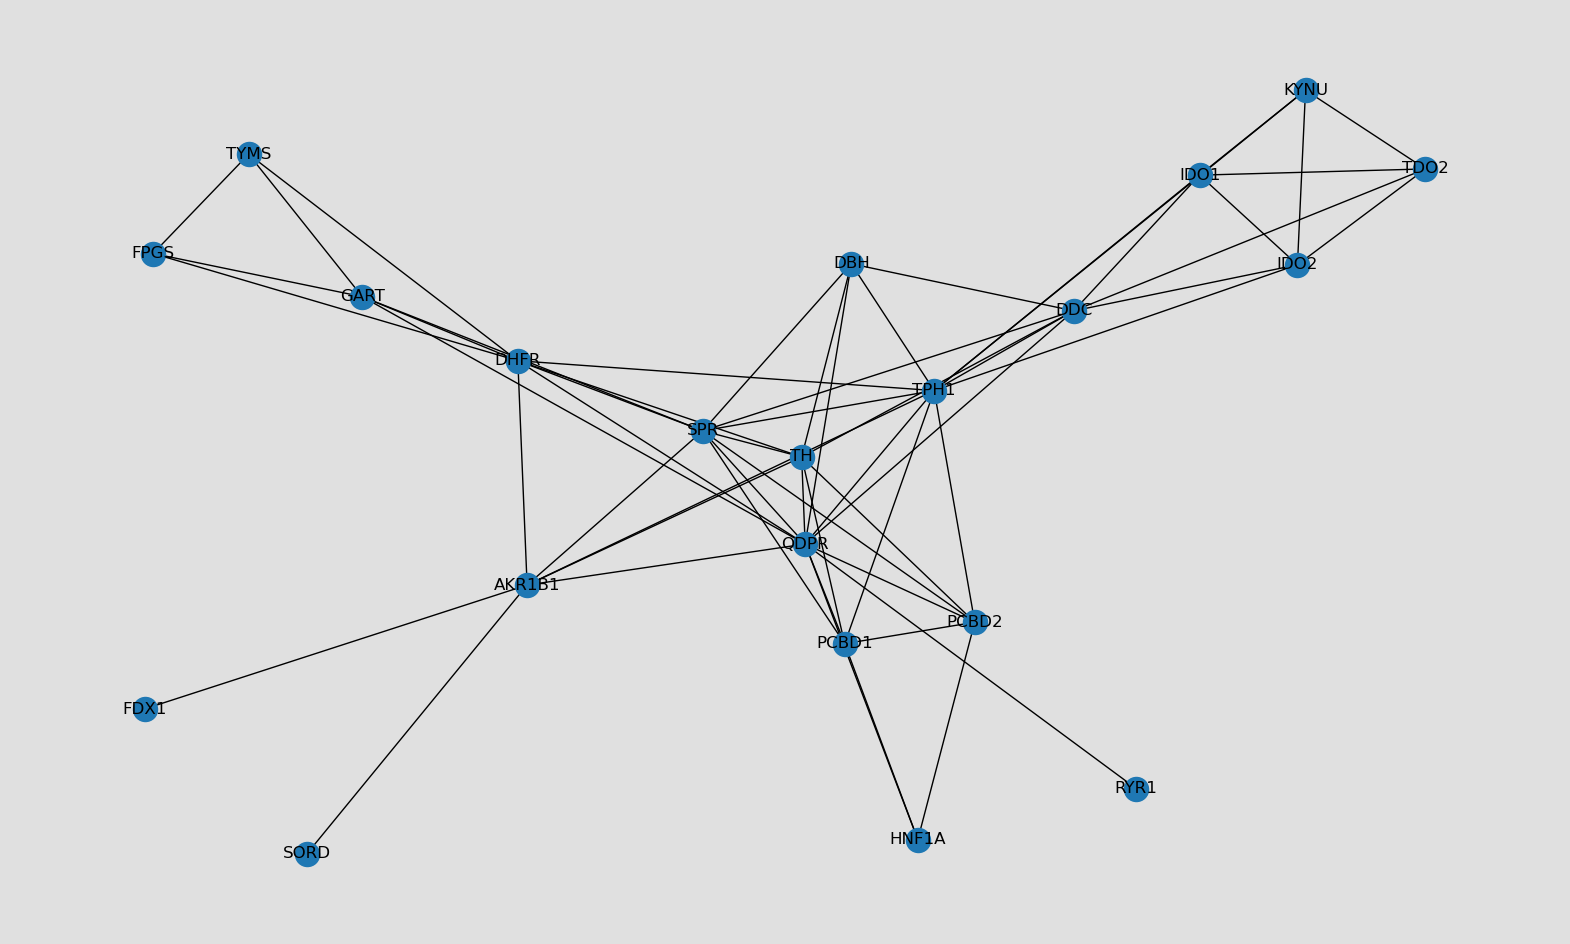

In [5]:
# Affichage du graphe
# nx.spring_layout is one of NetworkX’s node positioning algorithms.
pos = nx.spring_layout(G)  # positionner les noeuds en utilisant le placement en ressort
plt.figure(figsize=(20, 12), facecolor=[0.7, 0.7, 0.7, 0.4])
nx.draw_networkx(G)
plt.axis('off')
plt.show()

La visualisation simple montrée ci-dessus ne nous fournit pas beaucoup d'aide, c'est pourquoi nous essayons de personnaliser notre graphe en écrivant le code ci-dessous qui nous aidera de la manière suivante :

La gamme de couleurs va du violet foncé au jaune vif.
Plus le nœud est jaune, plus son degré est élevé.
Plus le nœud est grand, plus sa centralité d'intermédiarité est élevée.
Plus l'arête est jaune et large, plus le score d'interaction (poid) est élevé.

In [6]:
# Fonction pour mettre à l'échelle une liste de valeurs dans une plage [newmin, newmax]
def rescale(l, newmin, newmax):
    arr = list(l)
    return [(x - min(arr)) / (max(arr) - min(arr)) * (newmax - newmin) + newmin for x in arr]

# Utiliser la colormap plasma de matplotlib
graph_colormap = cm.get_cmap('plasma', 12)
# La couleur des noeuds varie avec le degré
c = rescale([G.degree(v) for v in G], 0.0, 0.9)
c = [graph_colormap(i) for i in c]
# La taille des noeuds varie avec la centralité de l'intermédiarité - mise à l'échelle entre [10,100]
bc = nx.betweenness_centrality(G)  # centralité de l'intermédiarité
s = rescale([v for v in bc.values()], 1500, 7000)
# L'épaisseur des arêtes montre 1-poids pour convertir le coût en force de l'interaction
ew = rescale([float(G[u][v]['weight']) for u, v in G.edges], 0.1, 4)
# La couleur des arêtes montre également le poids
ec = rescale([float(G[u][v]['weight']) for u, v in G.edges], 0.1, 1)
ec = [graph_colormap(i) for i in ec]

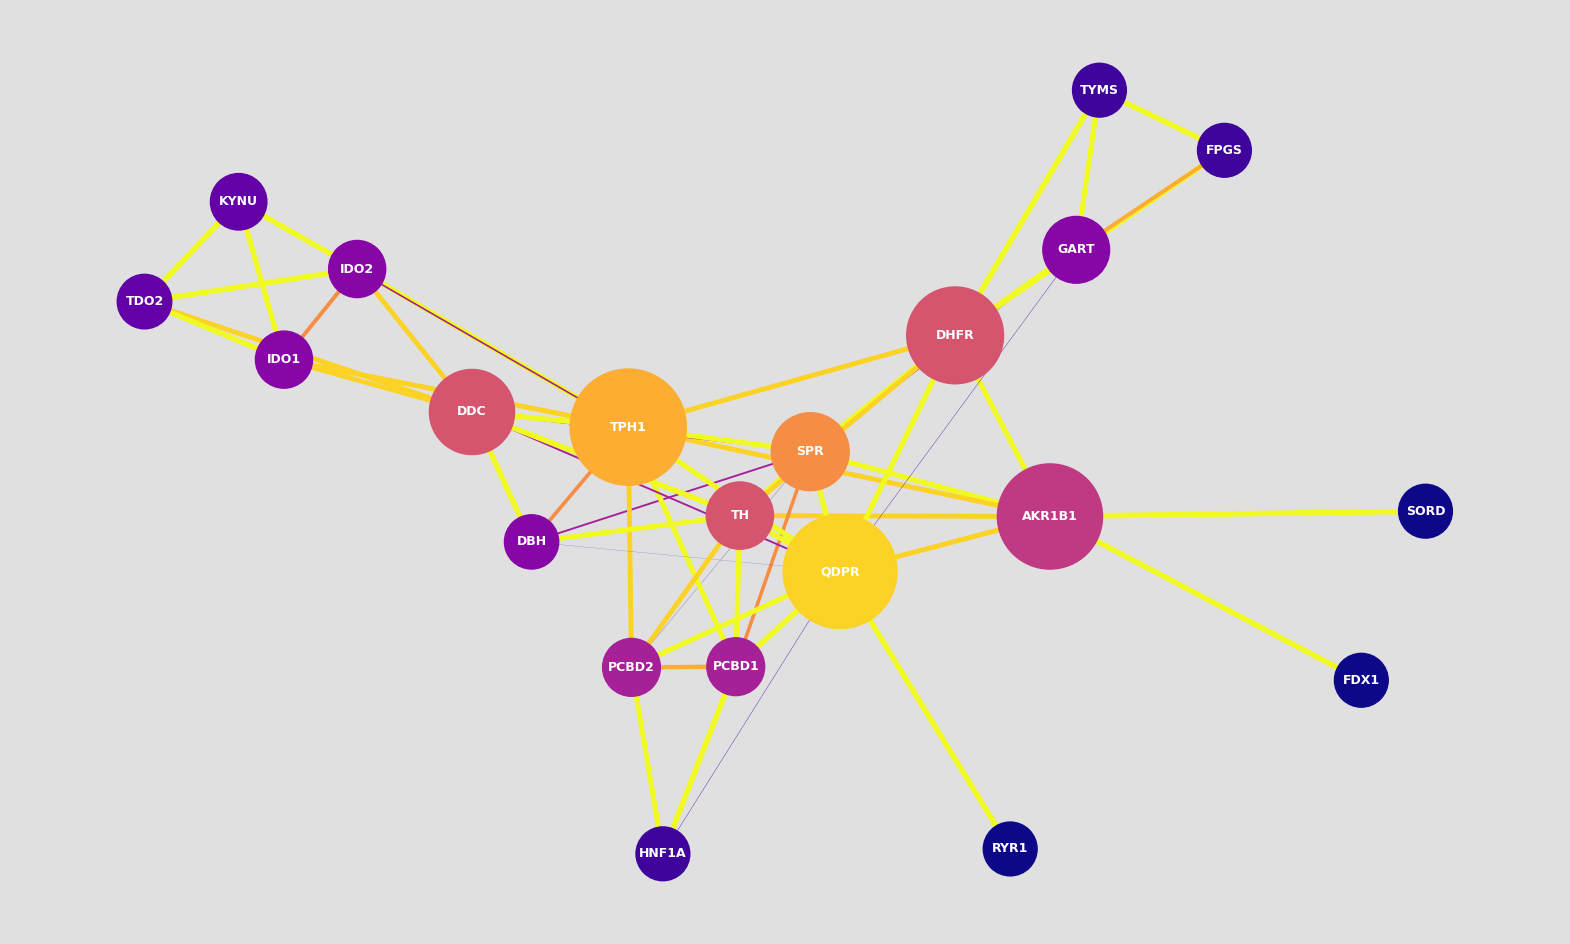

In [7]:
pos = nx.spring_layout(G)
plt.figure(figsize=(20, 12), facecolor=[0.7, 0.7, 0.7, 0.4])
nx.draw_networkx(G, pos=pos, with_labels=True, node_color=c, node_size=s, edge_color=ec, width=ew,
                 font_color='white', font_weight='bold', font_size='9')
plt.axis('off')
plt.show()

Rendons cela encore plus intéressant en essayant d'afficher l'arbre couvrant de poids minimum ("minimum spanning tree") :

Les arbres couvrants de poids minimum sont largement utilisés dans les réseaux de protéines-proteines (PPI) pour plusieurs applications. Par exemple :

Pour la prédiction de nouvelles interactions : En identifiant les arêtes de poids minimum manquantes dans l'arbre couvrant, on peut obtenir des indications sur de potentielles interactions non découvertes ou non documentées.
![3](./3.png)

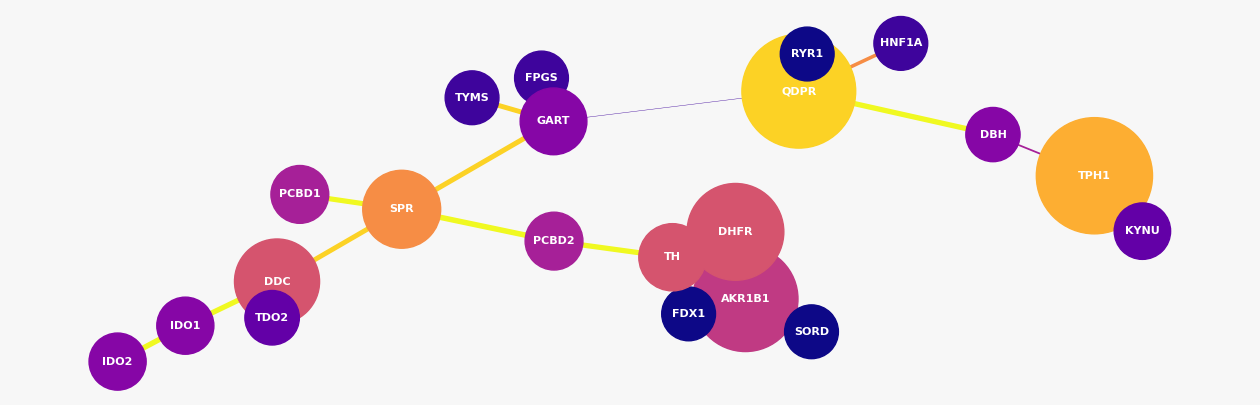

In [8]:
T = nx.minimum_spanning_tree(G)
pos = nx.spring_layout(T)
plt.figure(figsize=(16, 5), facecolor=[0.7, 0.7, 0.7, 0.1])
nx.draw_networkx(T, pos=pos, with_labels=True, node_color=c, node_size=s, edge_color=ec, width=ew,
                font_color='white', font_weight='bold', font_size='8')
plt.axis('off')
plt.show()

Finalement, essayons de réaliser l'isomorphisme entre deux graphes (nous utilisons une autre dataset des protéines SPR) :

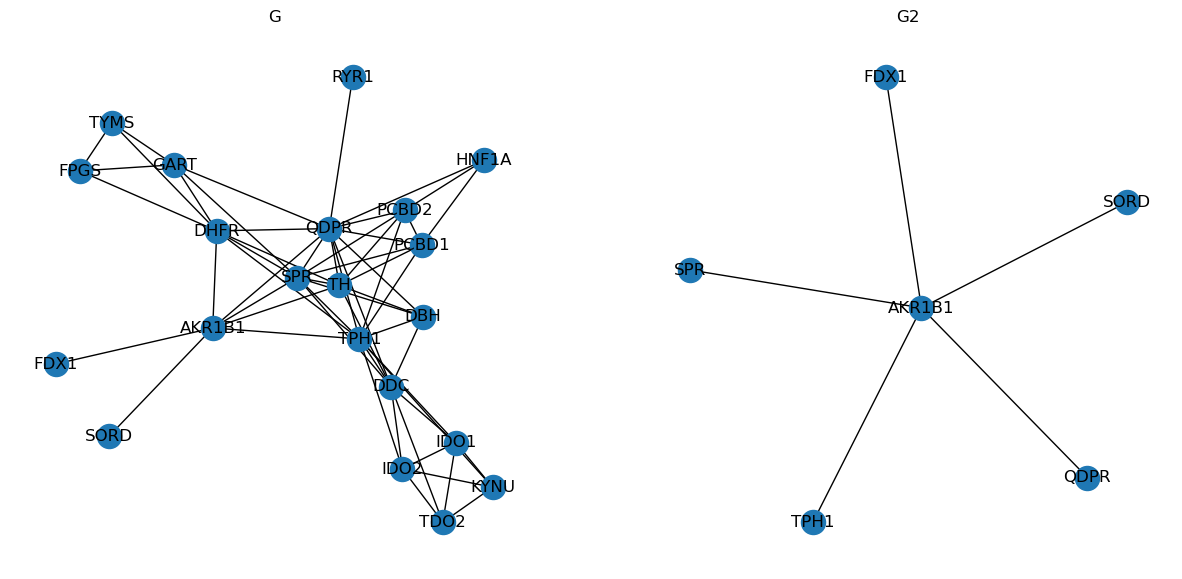

{'QDPR': 'AKR1B1', 'DDC': 'SPR', 'RYR1': 'TPH1', 'HNF1A': 'FDX1', 'GART': 'SORD', 'AKR1B1': 'QDPR'}
G2 est isomorphe à un sous-graphe de G.


In [9]:
df2 = pd.read_csv('./dataset1.tsv', delimiter='\t', skipfooter=1, engine='python')
interactions2 = df2[['#node1', 'node2', 'combined_score']]
G2 = nx.Graph(name="Graphe d'interaction des protéines 2")

interactions2 = np.array(interactions2)
for i in range(len(interactions2)):
    interaction = interactions2[i]
    a = interaction[0]  # noeud protéine a
    b = interaction[1]  # noeud protéine b
    w = float(interaction[2])  # score en tant qu'arête pondérée où les scores élevés = faible poids
    G2.add_weighted_edges_from([(a, b, w)])  # ajouter une arête pondérée au graphe

# Afficher les graphes initiaux
plt.figure(figsize=(15, 7))
plt.subplot(121)
nx.draw(G, with_labels=True)
plt.title("G")
plt.subplot(122)
nx.draw(G2, with_labels=True)
plt.title("G2")
plt.show()

# Créer l'objet de comparaison de graphes
gm = isomorphism.GraphMatcher(G, G2)

# Vérifier si G2 est isomorphe à un sous-graphe de G
is_isomorphic = False
for subgraph in gm.subgraph_isomorphisms_iter():
    if len(subgraph) == len(G2):
        print(subgraph)
        is_isomorphic = True
        break

# Afficher le résultat
if is_isomorphic:
    print("G2 est isomorphe à un sous-graphe de G.")
else:
    print("G2 n'est pas isomorphe à aucun sous-graphe de G.")


## Autres fonctions

In [10]:
nx.is_eulerian(G2)

False

In [11]:
nx.vf2pp_is_isomorphic(G, G2)

False

In [12]:
nx.maximal_matching(G)


{('AKR1B1', 'SPR'),
 ('HNF1A', 'PCBD2'),
 ('IDO1', 'KYNU'),
 ('IDO2', 'TDO2'),
 ('QDPR', 'DDC'),
 ('TH', 'DHFR'),
 ('TPH1', 'DBH'),
 ('TYMS', 'FPGS')}